In [5]:
#import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #For plotting
from sklearn.cluster import KMeans #Do K-Means clustering
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from kneed import KneeLocator #Find the knee of the WCSS vs K plot
from yellowbrick.cluster import silhouette_visualizer #Plot Silhouette plot
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'colab' 
%matplotlib inline


from decimal import Decimal

In [3]:
data = pd.read_csv('../data/online_shoppers_intention.csv')
data
print("\nTo check: \n (1) Total number of entries \n (2) Column types \n (3) Any null values\n")
print(data.info())


To check: 
 (1) Total number of entries 
 (2) Column types 
 (3) Any null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64 

In [ ]:
df = data[['ProductRelated', 'PageValues', 'Revenue']]
df['Total_Dur'] = data[['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']].sum(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
scaler = MinMaxScaler()
df[['ProductRelated', 'PageValues','Total_Dur']] = scaler.fit_transform(df[['ProductRelated', 'PageValues','Total_Dur']])

rev_int = df['Revenue'].apply(lambda x: 1 if x == True else 0)
df['Revenue'] = rev_int

df.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,ProductRelated,PageValues,Revenue,Total_Dur
count,12330.000000,12330.000000,12330.000000,12330.000000
mean,0.045009,0.016279,0.154745,0.018736
std,0.063086,0.051328,0.361676,0.029144
min,0.000000,0.000000,0.000000,0.000000
25%,0.009929,0.000000,0.000000,0.003175
50%,0.025532,0.000000,0.000000,0.009725
75%,0.053901,0.000000,0.000000,0.023268
max,1.000000,1.000000,1.000000,1.000000


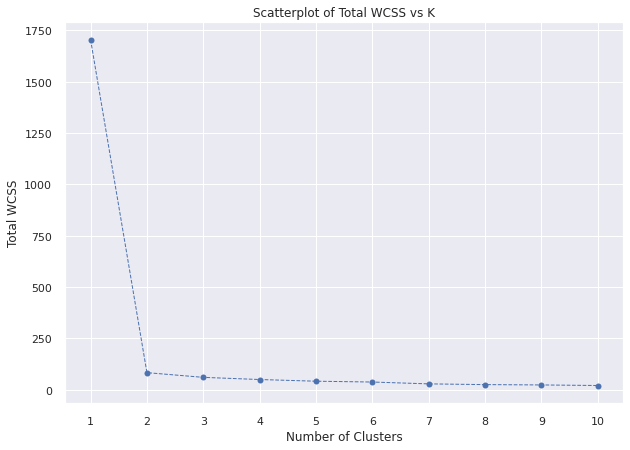

In [ ]:
wcss = []
max_k = 10 # NOTE: Try 10 and 20
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [ ]:
#To locate the elbow point of the curve using kneed package
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

2

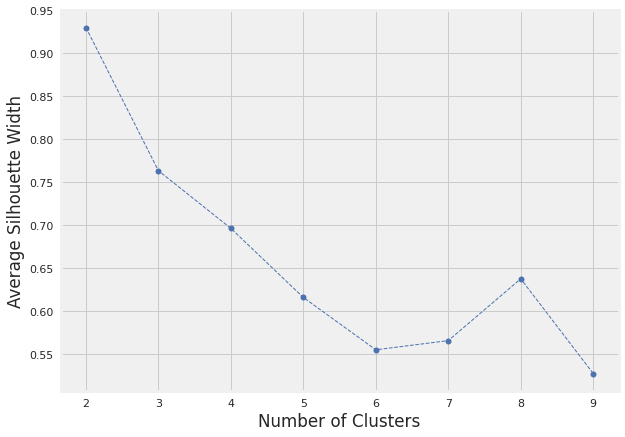

In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)
    

plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

#silhouette dictionary to track the silhouette scores for different k 
silhouette_dict = {}

#Fit kmeans labels onto our dataframe
#Input: df and int, Output:df 
def kmeans_label(data, num_clusters): 
  kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
  kmeans_model.fit(data.to_numpy())
  data2 = data.copy()
  labels = kmeans_model.labels_
  data2['Clusters'] = pd.DataFrame(labels)
  return data2

In [ ]:
#Plot boxplots of each feature after attaching cluster label in each row
#Input: df with labels, Output: plt graphs
def plot_boxplots(data_with_label):
  plt.figure(figsize=(30,30))
  sns.set(font_scale = 2)
  for i in range(len(data_with_label.columns)-1):
    plt.subplot(4,4,i+1)
    sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 

In [ ]:
#Plot the silhouettes
#Input: df, Output: plt graphs
def plot_silhouettes(data,num_clusters):
  # dataarray = data.to_numpy()
  model = KMeans(init="random",n_clusters=num_clusters,random_state=42)
  plt.figure(figsize=(10, 7)) 
  sns.set(font_scale = 1)
  silhouette_visualizer(model, data, colors='yellowbrick')
  score = silhouette_score(data, model.labels_,metric = 'euclidean')
  if num_clusters not in silhouette_dict.keys():
    silhouette_dict[num_clusters] = score
  print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))

In [ ]:
kmeans4 = KMeans(init="random",n_clusters =4 , random_state = 42)
kmeans4.fit(df)
clustergroups3 = kmeans4.labels_ #The cluster number for each row

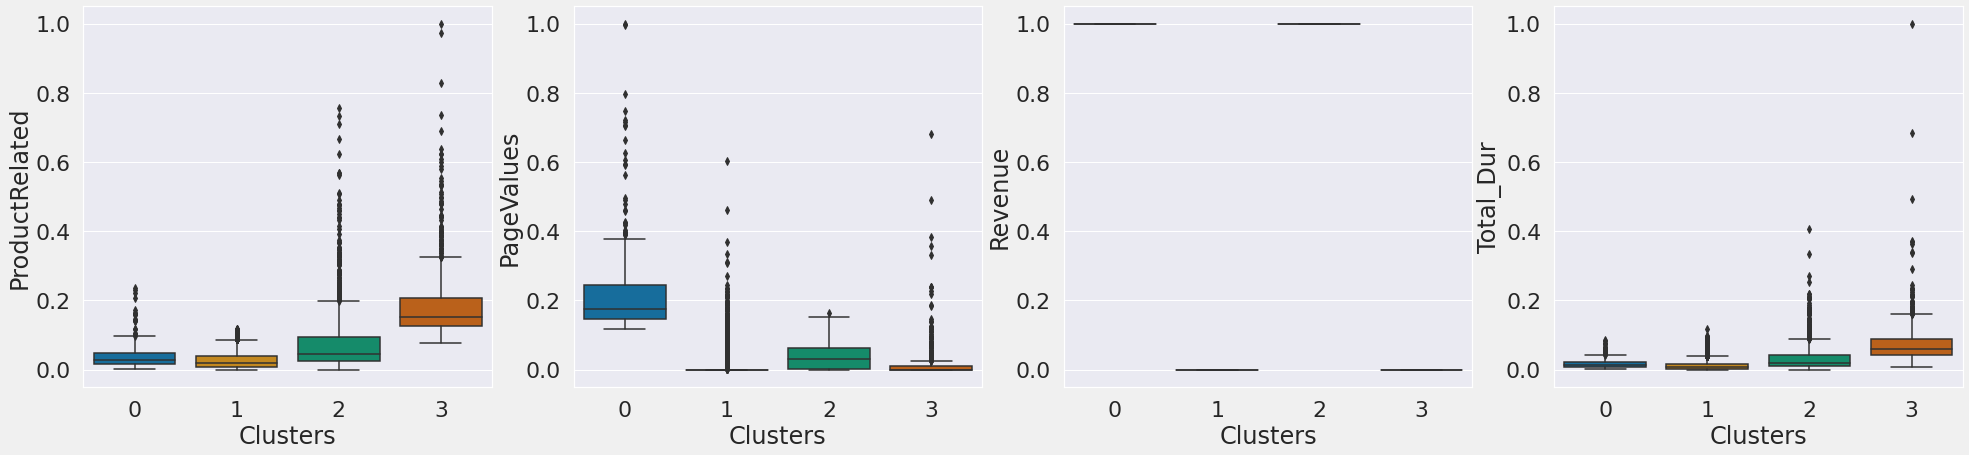

In [ ]:
Clustercenters4 = pd.DataFrame(kmeans4.cluster_centers_) #Dataframe of cluster centers
Clustercenters4.rename(columns={0: "ProductRelated", 1: "PageValues", 2: "Revenue", 3: "Total_Dur"},inplace=True)
Clustercenters4.index.name = "Clusters"
Clustercenters4

model4 = kmeans_label(df, 4) #Attach kmeans_labels to our data
model4.head()

plot_boxplots(model4)

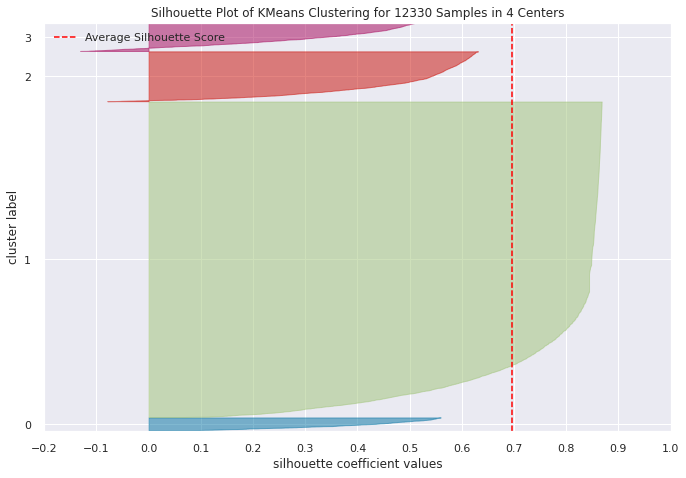

For n_clusters = 4 The average silhouette_score is: 0.6961063294274854 


In [ ]:
plot_silhouettes(df,4)

In [ ]:
kmeans5 = KMeans(init="random",n_clusters =5 , random_state = 42)
kmeans5.fit(df)
clustergroups5 = kmeans5.labels_ #The cluster number for each row

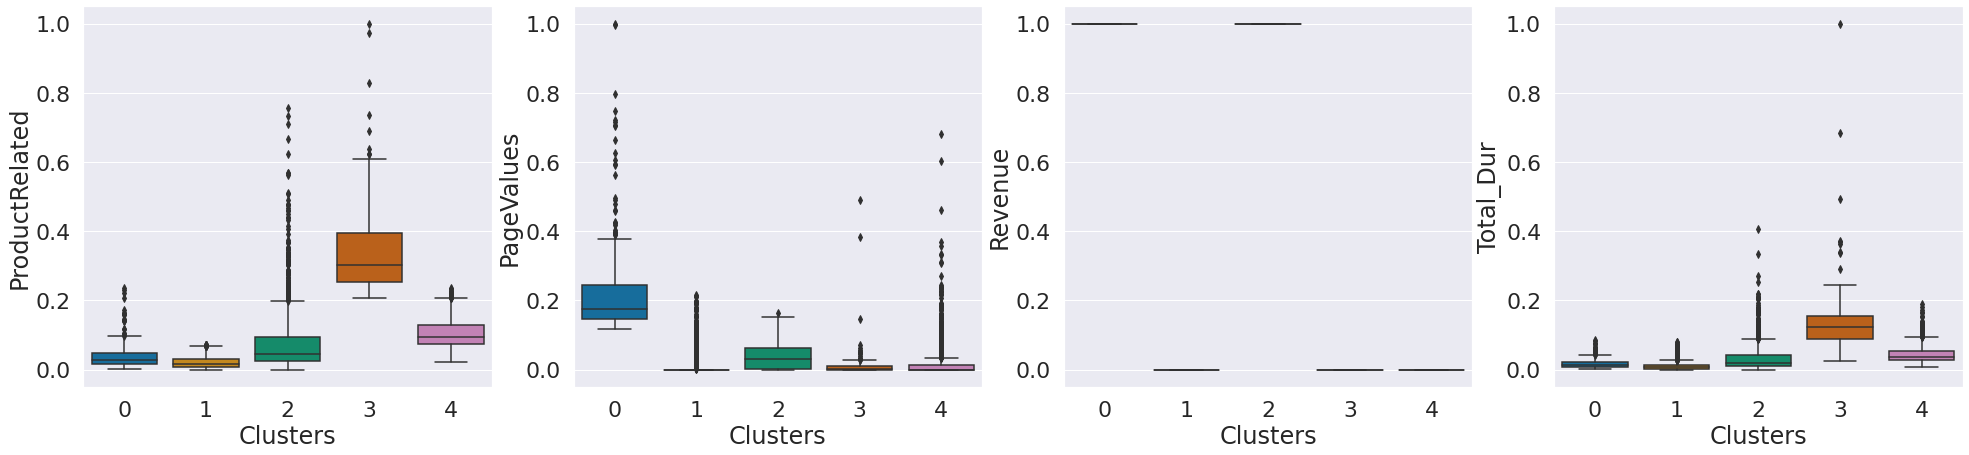

In [ ]:
Clustercenters5 = pd.DataFrame(kmeans5.cluster_centers_) #Dataframe of cluster centers
Clustercenters5.rename(columns={0: "ProductRelated", 1: "PageValues", 2: "Revenue", 3: "Total_Dur"},inplace=True)
Clustercenters5.index.name = "Clusters"
Clustercenters5

model5 = kmeans_label(df, 5) #Attach kmeans_labels to our data
model5.head()

plot_boxplots(model5)

0: Search/Deliberation (Relatively high ProductRelated+PageValues+Dur, Purchase)

1: Hedonic Browsing (Relatively low ProductRelated+Dur, High PageValues, Purchase)

2: Directed Buying (Low ProductRelated+PageValues+Dur, Purchase)

3: Knowledge Building (High ProductRelated+Dur, Low PageValues, No Purchase)

4: Shallow (Low ProductRelated+PageValues+Dur, No Purchase)

In [ ]:
print(scaler.data_min_)
print(scaler.data_max_)
print(scaler.scale_)

[0. 0. 0.]
[  705.          361.7637419 69921.64723  ]
[1.41843972e-03 2.76423501e-03 1.43017226e-05]


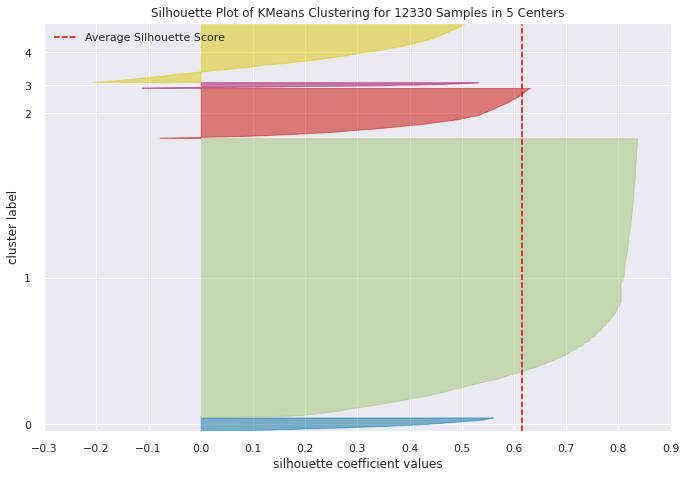

For n_clusters = 5 The average silhouette_score is: 0.6156264065941792 


In [ ]:
plot_silhouettes(df,5)

In [ ]:
for i in range(0,5):
    print('\nCluster {}:'.format(i))
    print(model5[model5['Clusters'] == i].describe())


Cluster 0:
       ProductRelated  PageValues  Revenue   Total_Dur  Clusters
count      396.000000  396.000000    396.0  396.000000     396.0
mean         0.037599    0.216955      1.0    0.016509       0.0
std          0.034503    0.123338      0.0    0.014308       0.0
min          0.001418    0.116182      1.0    0.000223       0.0
25%          0.015603    0.146862      1.0    0.007013       0.0
50%          0.026950    0.173612      1.0    0.012314       0.0
75%          0.048227    0.243099      1.0    0.021393       0.0
max          0.236879    1.000000      1.0    0.086024       0.0

Cluster 1:
       ProductRelated   PageValues  Revenue    Total_Dur  Clusters
count     8464.000000  8464.000000   8464.0  8464.000000    8464.0
mean         0.020946     0.002854      0.0     0.008814       1.0
std          0.016537     0.015328      0.0     0.009560       0.0
min          0.000000     0.000000      0.0     0.000000       1.0
25%          0.007092     0.000000      0.0     0.001845